In [17]:
import pandas as pd

In [18]:
custom_date_parser = lambda x: datetime.strptime(x, "%Y-%d-%m %H:%M:%S")
df = pd.read_csv('com-data.csv', parse_dates = True, date_parser = custom_date_parser)
df.drop('Timestamp (Unix)', axis = 1, inplace = True)
df['Timestamp (Day Time(cst))'] = pd.to_datetime(df['Timestamp (Day Time(cst))'])
df['Timestamp (Day Time(cst))']

0      2022-02-10 17:00:00
1      2022-02-10 17:01:00
2      2022-02-10 17:01:00
3      2022-02-10 17:10:00
4      2022-02-10 17:14:00
               ...        
3447   2022-02-15 13:14:00
3448   2022-02-15 12:30:00
3449   2022-02-15 12:36:00
3450   2022-02-15 12:46:00
3451   2022-02-15 13:04:00
Name: Timestamp (Day Time(cst)), Length: 3452, dtype: datetime64[ns]

In [19]:
df = df[2400:]

In [20]:
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from pylab import rcParams
import matplotlib
from matplotlib import pyplot as plt

No handles with labels found to put in legend.


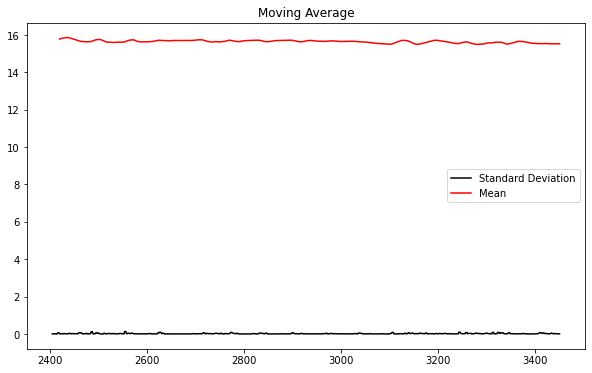

In [21]:
#if not stationary then eliminate trend
#Eliminate trend
df_corn = df['Soybean']
rcParams['figure.figsize'] = 10, 6
df_log = df_corn
moving_avg = df_log.rolling(20).mean()
std_dev = df_log.rolling(5).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

In [22]:
df_log

2400    15.733077
2401    15.749290
2402    15.745829
2403    15.749133
2404    15.738354
          ...    
3447    15.497137
3448    15.479629
3449    15.475608
3450    15.490396
3451    15.487765
Name: Soybean, Length: 1052, dtype: float64

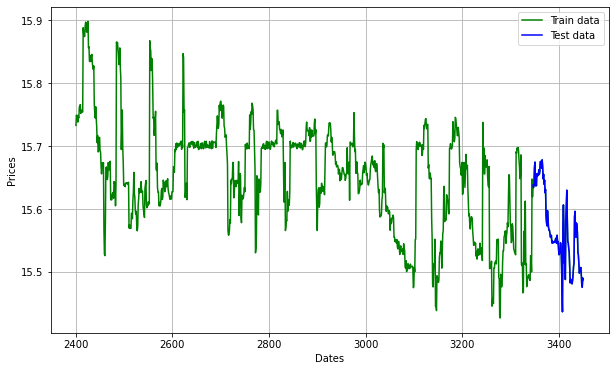

In [23]:
size = round(len(df_log) * .9)
train, test = df_log[0:size], df_log[size:]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=7899.206, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-3943.904, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-3942.151, Time=0.14 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-3942.003, Time=0.14 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.53 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-3941.948, Time=0.79 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-3982.530, Time=0.26 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-2844.248, Time=0.28 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-3982.244, Time=0.15 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-3980.457, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-3980.687, Time=0.64 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-1

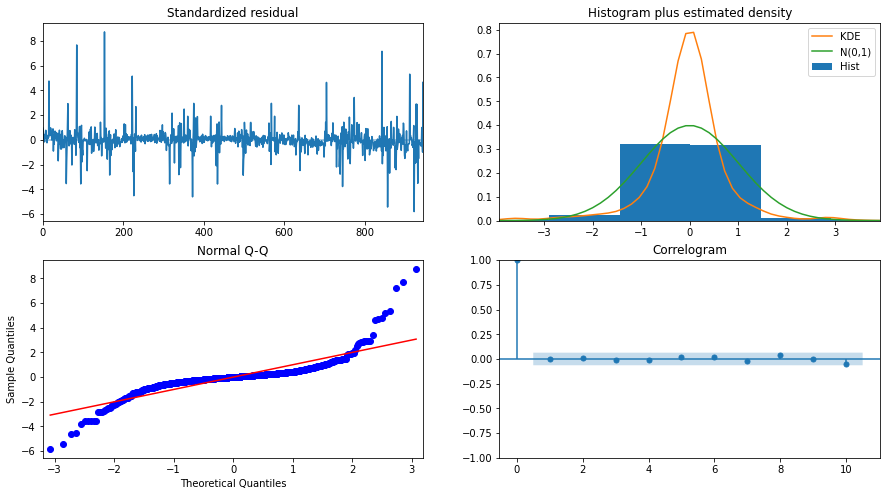

In [24]:
model_autoARIMA = auto_arima(train, start_p=0, start_q=0,test='adf',max_p=3, max_q=3,m=1,d=None,seasonal=False,start_P=0, D=0,trace=True,error_action='ignore',suppress_warnings=True,stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [25]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df['Wheat'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -4.620652
p-value: 0.000118


In [26]:
model = ARIMA(train, order=(2, 0, 0))  
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                Soybean   No. Observations:                  947
Model:                 ARIMA(2, 0, 0)   Log Likelihood                1995.331
Date:                Wed, 16 Feb 2022   AIC                          -3982.663
Time:                        09:50:22   BIC                          -3963.250
Sample:                             0   HQIC                         -3975.265
                                - 947                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.6526      0.017    935.276      0.000      15.620      15.685
ar.L1          0.8893      0.033     27.160      0.000       0.825       0.953
ar.L2          0.0506      0.032      1.558      0.1

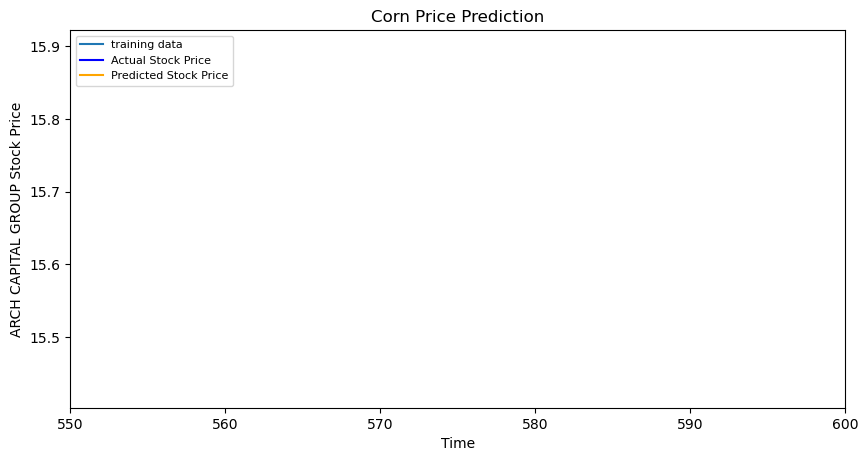

In [27]:
# Forecast
fc = fitted.forecast(len(test), alpha=0.05)  # 95% conf
# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
# lower_series = pd.Series(conf[:, 0], index=test.index)
# upper_series = pd.Series(conf[:, 1], index=test.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train, label='training data')
plt.plot(test, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
# plt.fill_between(lower_series.index, lower_series, upper_series, 
#                  color='k', alpha=.10)
plt.title('Corn Price Prediction')
plt.xlabel('Time')
plt.ylabel('ARCH CAPITAL GROUP Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.xlim([550, 600])
plt.show()

In [28]:
# report performance
mse = mean_squared_error(test, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test)/np.abs(test))
print('MAPE: '+str(mape))

MSE: 0.010708372387270034
MAE: 0.08881506647244086
RMSE: 0.1034812658758581
MAPE: 0.005717942193846085


In [29]:
from joblib import dump, load
dump(fitted, 'soy_arima.model')

['soy_arima.model']